----
# Sneaky Fox Problem
----

In [36]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt


CROSS = '❌'
FOX = '🦊'
CHOICE = '🎯'
def step(state, next_choice):
    next_state = ""
    n = len(state)
    for i in range(n):
        if i == next_choice:
            next_state += CHOICE
        else:
            get_fox = False
            if i == 0:
                if state[1] == FOX: 
                    get_fox = True
            elif i == n -1:
                if state[n -2] == FOX:
                    get_fox = True
            else:
                if FOX in [state[i -1], state[i + 1]]:
                    get_fox = True
            next_state += FOX if get_fox else CROSS
    return next_state
       
            
def possible_next(state):
    return [step(state, i) for i in range(len(state))]

def mutate(state, i, sym):
    return state[:i] + sym + state[i+1:]

def unemojify(state):
    mapping = {
        FOX: "F",
        CROSS: "X",
        CHOICE: "C"
    }
    return ''.join([mapping[x] for x in state])

def unemojify_graph(graph):
    return {unemojify(key): [unemojify(state) for state in val] for key, val in graph.items()}


def generate_graph(n, all_end_states=True):
    """
    Getting to one of the end state is somewhat like Dikjastra algorithm....?
    """
    init_state = FOX * n
    if all_end_states:
        graph_dict = {mutate(CROSS * n, i, CHOICE): [] for i in range(n)}
    else:
        graph_dict = {mutate(CROSS * n, 1, CHOICE): []}

    unexplored = [init_state]
    while unexplored:
        current_state = unexplored.pop()

        graph_dict[current_state] = []
        successors = possible_next(current_state)
        for state in successors:
            graph_dict[current_state].append(state)
            if state not in graph_dict and state.count(FOX) > 0:
                unexplored.append(state)
    return graph_dict
    

---
# Problem statement
There is `n`-holes arranged in a row where a fox can hide. Each morning, the farmer can have a shot at guessing which hole the fox is in and each night, the fox **must** move to an ajacent hole. That means, if the fox is on one of the two boundary holes, it must move to the only adjecent hole that night otherwise he must choose between one of the two adjacent hole if it is in the non-boundary holes. 

**Question**: Is there a way for the farmer to choose holes that guarantee that he will eventually catch the fox? 


----
## Case: $n = 1, 2, 3$ 
For $n = 1$, the human always win in the $d = 1$ day. 
For the $n = 2$ case, human always win with at most $d = 2$ days by just picking any one position twice in a row. 
For $n = 3$, human always win with at most $d = 2$ days by keep picking the middle hole. 
Either the fox start of at the middle or it has to move to the middle from the boundary holes. 
So the boundary is important. 


---
## Case $n = 4$
For n = 4, you can pick the the second hole twice in a row times to rule out the possibility of the fox to ever be in the first two holes. And I can switch to the 3rd hole on the 3rd day and I can know for sure that the fox is on hole 2 on the 3rd day (otherwise keep picking hole 3 will catch it the next day). So I can pick the 3rd hole again to make sure that the fox have to jump to hole 1 and then pick up the fox at at most d = 5 days. 

So maybe there is something about eliminate one side of the boundary making it a smaller problem until you can information about exactly where the fox is (if you haven’t catch it already).



----
## Reformulation as graph topology problem. 
This problem can be restated as finding a path in a graph $G$ whose vertices are generated by the initial state
🦊🦊🦊🦊
with the 🦊's representing the possible location of the fox on day 0 ($n = 4$ in this case). There is exactly $n$ neighbours for each vertex corresponding to each choices, 🎯, the farmer make the next day and the possible location the fox can be in without getting caught base on the choice. (i.e. the fox has perfect information and aim to stay uncaught for as long as possible)


For example,

In [8]:
for state in ["🦊🦊🦊🦊", '🎯❌🦊❌', '🦊🎯🦊❌', '🦊❌🎯❌', '🦊❌🦊🎯']:
    print(state, '--->', possible_next(state))

🦊🦊🦊🦊 ---> ['🎯🦊🦊🦊', '🦊🎯🦊🦊', '🦊🦊🎯🦊', '🦊🦊🦊🎯']
🎯❌🦊❌ ---> ['🎯🦊❌🦊', '❌🎯❌🦊', '❌🦊🎯🦊', '❌🦊❌🎯']
🦊🎯🦊❌ ---> ['🎯🦊❌🦊', '❌🎯❌🦊', '❌🦊🎯🦊', '❌🦊❌🎯']
🦊❌🎯❌ ---> ['🎯🦊❌❌', '❌🎯❌❌', '❌🦊🎯❌', '❌🦊❌🎯']
🦊❌🦊🎯 ---> ['🎯🦊❌🦊', '❌🎯❌🦊', '❌🦊🎯🦊', '❌🦊❌🎯']


With this formulation, the problem can be restated as 
> Starting from initial state of $\underbrace{🦊🦊🦊\dots🦊}_{n}$, can we reach an end state?  
An end state is a vertex where there is no 🦊's, i.e. one of  
$🎯❌❌\dots❌$  
$❌🎯❌\dots❌$  
$\dots$  
$❌❌\dots❌🎯$

Or in terms of the graph $G$, we are asking if the connected component with the initial state contains an end state. 
For the $n = 4$ case, the follow hole sequence defines a path from the initial to final state:

In [12]:
init_state = FOX * 4
print(init_state)

hole_sequence = [1, 1, 2, 2, 1]
current_state = init_state
for i in hole_sequence:
    current_state = step(current_state, i)
    print(current_state)
print("----- end state reached -----")

d0 = possible_next(init_state)
print(d0)
d1 = possible_next(d0[1])  # choose hole 2 on day 1
print(d1)
d2 = possible_next(d1[1])  # choose hole 2 on day 2 
print(d2)
d3 = possible_next(d2[2])  # choose hole 3 on day 3 
print(d3)
d4 = possible_next(d3[2])  # choose hole 3 on day 4, 
print(d4)
d5 = possible_next(d4[1])  # and observe that choose hole 2 the next day guarantees the catch
print(d5)


🦊🦊🦊🦊
🦊🎯🦊🦊
❌🎯🦊🦊
❌🦊🎯🦊
🦊❌🎯❌
❌🎯❌❌
----- end state reached -----
['🎯🦊🦊🦊', '🦊🎯🦊🦊', '🦊🦊🎯🦊', '🦊🦊🦊🎯']
['🎯🦊🦊🦊', '❌🎯🦊🦊', '❌🦊🎯🦊', '❌🦊🦊🎯']
['🎯🦊🦊🦊', '❌🎯🦊🦊', '❌🦊🎯🦊', '❌🦊🦊🎯']
['🎯❌🦊❌', '🦊🎯🦊❌', '🦊❌🎯❌', '🦊❌🦊🎯']
['🎯🦊❌❌', '❌🎯❌❌', '❌🦊🎯❌', '❌🦊❌🎯']
['🎯❌❌❌', '❌🎯❌❌', '❌❌🎯❌', '❌❌❌🎯']


We can visualise the graph. Below illustrates the $n = 4$ case. 


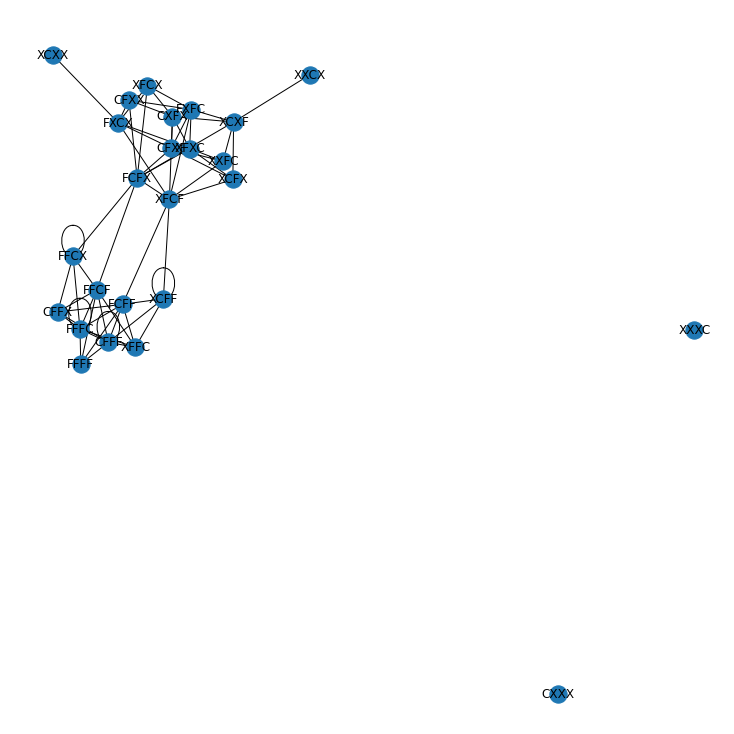

In [33]:
graph_dict = generate_graph(4)
g = nx.from_dict_of_lists(unemojify_graph(graph_dict))
plt.figure(figsize=(10, 10))
nx.draw(g, with_labels=True)


---
## Case $n = 5$
For the n = 5 case …


In [35]:
init_state = FOX * 5
print(init_state)

hole_sequence = [1, 1, 2, 3, 3, 2, 1]
current_state = init_state
for i in hole_sequence:
    current_state = step(current_state, i)
    print(current_state)

print("----- end state reached -----")


🦊🦊🦊🦊🦊
🦊🎯🦊🦊🦊
❌🎯🦊🦊🦊
❌🦊🎯🦊🦊
🦊❌🦊🎯🦊
❌🦊❌🎯❌
🦊❌🎯❌❌
❌🎯❌❌❌
----- end state reached -----


# Explore graph for different $n$
Some interesting observations (based on plotting the graph up to $n = 10$): 
 * Clearly, there is a mirror symmetry in the problem that shows up in the symmetry of the graph.. 
 * There seems to be only one connected component in the graph with more than 1 vertex. 
 * That dominant component contains both the initial and final vertex: **this solves our problem with an affirmative**. 
 * There is only end states in the dominant component (i.e. the solution) correspond to catching the fox in the second hole on the final day (and the mirror symmetric version, i.e. the second last hole).
 * More than that, it seems like the only way to guarantee catching the fox seems to be cornering the fox to three holes on the boundary and then pounce on it when we know that it must move to the second hole the next day.
 * There also seem to be only one path (other than mirror state) that connect the high fox count states with the end state. 
 
The last few statements seems to be provable by reasoning backwards from the possible end states. 


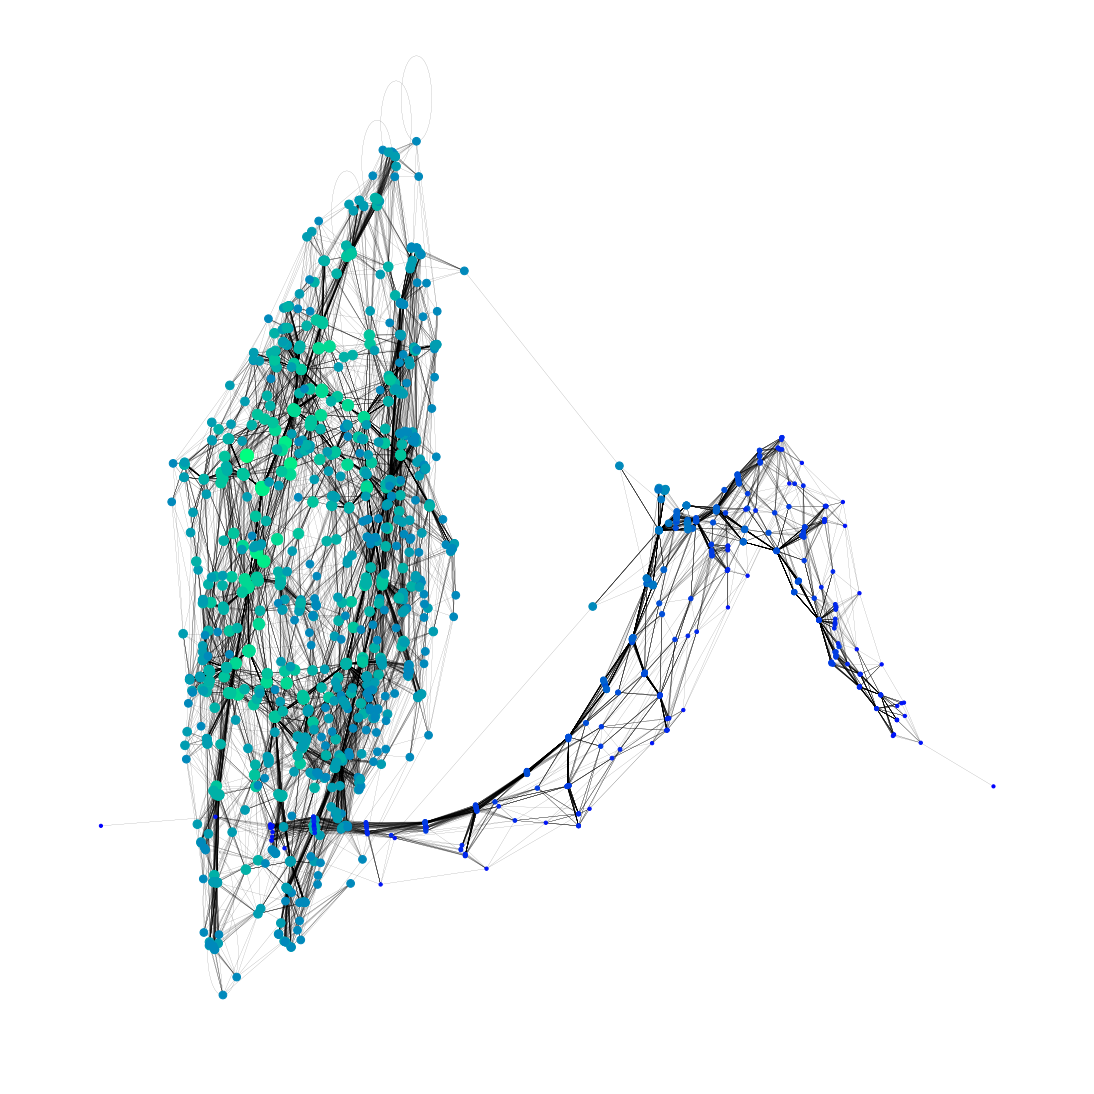

In [75]:
n = 13
show_all_end_states = False


graph_dict = generate_graph(n, all_end_states=show_all_end_states)
g = nx.from_dict_of_lists(unemojify_graph(graph_dict))
node_list = list(g)
fox_count = np.array([state.count("F") for state in node_list])

plt.figure(figsize=(15, 15))
nx.draw(
    g, 
    with_labels=False,
    font_size=10,
    nodelist=node_list,
    node_color=fox_count,
    cmap='winter',
    node_size=np.array(fox_count)**2 + 10,
    width=0.1
)